In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
import joblib

In [2]:
#Demo dosyamda hem en iyi Yöntem 1 modelimi hem de en iyi yöntem 2 modelimi kullanacağım

In [3]:
#Demo ayarlarım modeller düzgün çalışsın diye
img_dims = (64, 64)
batch_sz = 32
cnn_path = "best_model_64x64.keras"
svm_path = "model_hog_svm.pkl"
test_root = "demo_inputs/20"

In [4]:
cnn_model = load_model(cnn_path)
svm_model = joblib.load(svm_path)

/opt/anaconda3/envs/cnn_env/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
#Sayın Hocam HOG öznitelik çıkarımı yapmadan svm modelim çalışmayacağı için öznitelik çıkarımı yapıyorum
def get_hog_features(img_arr):
    gray_img = tf.image.rgb_to_grayscale(img_arr).numpy().squeeze()
    hog_feats = hog(
        gray_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return hog_feats

In [6]:
#Demo sırasında sadece bir resmi tahmin etmek için yazdığım kod
def run_single_demo(img_path):

    test_loader = ImageDataGenerator(rescale=1. / 255)

    test_set = test_loader.flow_from_directory(
        test_root,
        target_size=img_dims,
        batch_size=batch_sz,
        class_mode='categorical',
        shuffle=False
    )

    labels = list(test_set.class_indices.keys())

    img = image.load_img(img_path, target_size=img_dims)
    img_arr = image.img_to_array(img) / 255.0
    img_arr_exp = np.expand_dims(img_arr, axis=0)

    # CNN tahmini
    cnn_probs = cnn_model.predict(img_arr_exp)
    cnn_pred = labels[np.argmax(cnn_probs)]

    # HOG + SVM tahmini
    hog_input = get_hog_features(img_arr)
    svm_pred = svm_model.predict([hog_input])[0]
    pred_class_svm = labels[int(svm_pred)]


    # Resim ve tahminler
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"CNN: {cnn_pred} | HOG+SVM: {pred_class_svm}")
    plt.show()


In [15]:
#   Birden fazla resim test etme kodu 
def run_folder_demo(folder):
    #kodun cnn kısmı test dosyamdaki haline çevirdim
    test_loader = ImageDataGenerator(rescale=1. / 255)

    test_set = test_loader.flow_from_directory(
        test_root,
        target_size=img_dims,
        batch_size=batch_sz,
        class_mode='categorical',
        shuffle=False
    )
    
    label_list = list(test_set.class_indices.keys())
    true_cnn_labels = test_set.classes
    
    # CNN tahmini
    cnn_probs = cnn_model.predict(test_set)
    cnn_preds = np.argmax(cnn_probs, axis=1)
    
    print("\n--- CNN Classification ---")
    print(classification_report(true_cnn_labels, cnn_preds, target_names=label_list))
    print(f"Accuracy (CNN): {accuracy_score(true_cnn_labels, cnn_preds):.2f}") 

    true_svm, pred_svm = [], []

    # Sırayla tüm classları gez
    for class_name in os.listdir(test_root):
        class_folder = os.path.join(test_root, class_name)
        if not os.path.isdir(class_folder) or class_name not in label_list:
            continue
    
        for img_file in os.listdir(class_folder) :
            full_path = os.path.join(class_folder, img_file)
    
            try:
                img = load_img(full_path, target_size=img_dims)
                img_arr = img_to_array(img) / 255.0
    
                # HOG + SVM Tahmini
                hog_feat = get_hog_features(img_arr)
                svm_out = svm_model.predict([hog_feat])[0]
    
                pred_svm.append(int(svm_out))
                true_svm.append(label_list.index(class_name))
    
            except Exception as e:
                print()
    
    # Svm sonuçları
    print("\n--- SVM Classification ---")
    print(classification_report(true_svm, pred_svm, target_names=label_list))
    print(f"Accuracy (SVM): {accuracy_score(true_svm, pred_svm):.2f}")



>>> Single Image Evaluation
Found 20 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


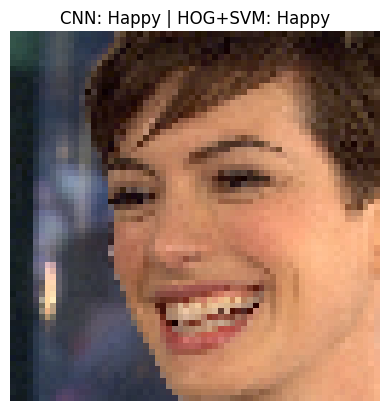


>>> Batch Folder Evaluation
Found 20 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

--- CNN Classification ---
              precision    recall  f1-score   support

       Angry       1.00      0.75      0.86         4
       Happy       0.67      1.00      0.80         4
     Neutral       0.43      0.75      0.55         4
         Sad       0.67      0.50      0.57         4
    Surprise       1.00      0.25      0.40         4

    accuracy                           0.65        20
   macro avg       0.75      0.65      0.63        20
weighted avg       0.75      0.65      0.63        20

Accuracy (CNN): 0.65






/opt/anaconda3/envs/cnn_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()









--- SVM Classification ---
              precision    recall  f1-score   support

       Angry       1.00      0.75      0.86         4
       Happy       0.67      1.00      0.80         4
     Neutral       1.00      1.00      1.00         4
         Sad       0.80      1.00      0.89         4
    Surprise       1.00      0.50      0.67         4

    accuracy                           0.85        20
   macro avg       0.89      0.85      0.84        20
weighted avg       0.89      0.85      0.84        20

Accuracy (SVM): 0.85


In [16]:
# Demo çalıştırma kodu
print("\n>>> Single Image Evaluation")
run_single_demo("demo_inputs/tek_resim/sample.jpg")

print("\n>>> Batch Folder Evaluation")
run_folder_demo(test_root)